# plaq-u-net: multi-patch consensus U-Net for automated detection and segmentation of the carotid arteries on black blood MRI sequences

E. Lavrova, 2022

This is a code supporting the corresponding paper.

Packages import:

In [1]:
import numpy as np
import os
import glob
from skimage.measure import label
import pydicom
import matplotlib.pyplot as plt
import pandas as pd
from skimage import morphology
from scipy.stats import iqr
from scipy.stats import binom_test

from sklearn.metrics import mean_squared_error

import seaborn as sns

C:\Users\E.Lavrova\AppData\Roaming\Python\Python37\site-packages\pandas\compat\_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)


In [2]:
def calculate_dice(mask_1, mask_2):
    intersection = np.sum(mask_1*mask_2)
    sum_area = np.sum(mask_1) + np.sum(mask_2)
    return 2*intersection/sum_area

def calculate_overlap(mask_1, mask_2):
    o = 0
    if (np.sum(mask_1)>0)&(np.sum(mask_2)>0):
        intersection = np.sum(mask_1*mask_2)
        min_area = min(np.sum(mask_1), np.sum(mask_2))
        o =intersection/min_area
    if (np.sum(mask_1)==0)&(np.sum(mask_2)==0):
        o = 1
    return o

In [3]:
def path2array(dcm_path, cut=True):
    arr_dcm = pydicom.read_file(dcm_path, force = True)
    arr_dcm.file_meta.TransferSyntaxUID = pydicom.uid.ImplicitVRLittleEndian
    arr = arr_dcm.pixel_array
    if cut:
        arr = arr[8:-8,8:-8]
    pix_spc_ch = arr_dcm.PixelSpacing
    pix_spc = [float(pix_spc_ch[0]), float(pix_spc_ch[1])]
    sl_thick = arr_dcm.SliceThickness
    return arr, pix_spc, sl_thick

In [209]:
def detect_label(label_mask, gt_mask):
    
    mask_labeled = label(label_mask)
            
    labels = list(np.unique(mask_labeled))
    labels.remove(0)

    max_overlap = 0
    max_label = 100
    max_dice = 0            
        
    for l in labels:
        
        mask_label = (mask_labeled==l).astype(np.uint8)
        d = calculate_dice(mask_label, gt_mask)
        o = calculate_overlap(mask_label, gt_mask)

        if o>max_overlap:
            
            max_overlap = o
            max_label = l
            max_dice = d        
            
    return max_label, max_overlap, max_dice

In [5]:
import scipy.stats
import math
import random


def clopper_pearson(x, n, alpha=0.05):

    b = scipy.stats.beta.ppf
    lo = b(alpha / 2, x, n - x + 1)
    hi = b(1 - alpha / 2, x + 1, n - x)
    return 0.0 if math.isnan(lo) else lo, 1.0 if math.isnan(hi) else hi

In [6]:
def get_mask_from_map(vessel_map):
    
    vessel_map_processed = morphology.remove_small_objects(vessel_map>0.5, 50, connectivity=3)
    vessel_map_labeled = label(vessel_map_processed)

    label_weights = []

    for l in range(1, np.max(vessel_map_labeled)+1):
    
        vessel_map_label = (vessel_map_labeled==l).astype(np.uint8)
        weight_label = np.sum(vessel_map_label*vessel_map)
        rec_lw = {'label': l, 'weight': weight_label}
        label_weights.append(rec_lw)

    label_weights = pd.DataFrame(label_weights)
    n_labels = min(len(label_weights), 6)
    labels = []
            
    if len(label_weights)>0:

        label_weights.sort_values(by='weight', inplace=True, ascending = False)
        labels = np.array(label_weights['label'])[:n_labels]

    vessel_mask = np.isin(vessel_map_labeled, labels)
    
    return vessel_mask

In [7]:
from numpy import ones, kron, mean, eye, hstack, dot, tile
from numpy.linalg import pinv

def icc(Y, icc_type='ICC(2,1)'):
    ''' Calculate intraclass correlation coefficient

    ICC Formulas are based on:
    Shrout, P. E., & Fleiss, J. L. (1979). Intraclass correlations: uses in
    assessing rater reliability. Psychological bulletin, 86(2), 420.
    icc1:  x_ij = mu + beta_j + w_ij
    icc2/3:  x_ij = mu + alpha_i + beta_j + (ab)_ij + epsilon_ij
    Code modifed from nipype algorithms.icc
    https://github.com/nipy/nipype/blob/master/nipype/algorithms/icc.py

    Args:
        Y: The data Y are entered as a 'table' ie. subjects are in rows and repeated
            measures in columns
        icc_type: type of ICC to calculate. (ICC(2,1), ICC(2,k), ICC(3,1), ICC(3,k)) 
    Returns:
        ICC: (np.array) intraclass correlation coefficient
    '''

    [n, k] = Y.shape

    # Degrees of Freedom
    dfc = k - 1
    dfe = (n - 1) * (k-1)
    dfr = n - 1

    # Sum Square Total
    mean_Y = np.mean(Y)
    SST = ((Y - mean_Y) ** 2).sum()

    # create the design matrix for the different levels
    x = np.kron(np.eye(k), np.ones((n, 1)))  # sessions
    x0 = np.tile(np.eye(n), (k, 1))  # subjects
    X = np.hstack([x, x0])

    # Sum Square Error
    predicted_Y = np.dot(np.dot(np.dot(X, np.linalg.pinv(np.dot(X.T, X))),
                                X.T), Y.flatten('F'))
    residuals = Y.flatten('F') - predicted_Y
    SSE = (residuals ** 2).sum()

    MSE = SSE / dfe

    # Sum square column effect - between colums
    SSC = ((np.mean(Y, 0) - mean_Y) ** 2).sum() * n
    MSC = SSC / dfc  # / n (without n in SPSS results)

    # Sum Square subject effect - between rows/subjects
    SSR = SST - SSC - SSE
    MSR = SSR / dfr

    if icc_type == 'icc1':
        # ICC(2,1) = (mean square subject - mean square error) /
        # (mean square subject + (k-1)*mean square error +
        # k*(mean square columns - mean square error)/n)
        # ICC = (MSR - MSRW) / (MSR + (k-1) * MSRW)
        NotImplementedError("This method isn't implemented yet.")

    elif icc_type == 'ICC(2,1)' or icc_type == 'ICC(2,k)':
        # ICC(2,1) = (mean square subject - mean square error) /
        # (mean square subject + (k-1)*mean square error +
        # k*(mean square columns - mean square error)/n)
        if icc_type == 'ICC(2,k)':
            k = 1
        ICC = (MSR - MSE) / (MSR + (k-1) * MSE + k * (MSC - MSE) / n)

    elif icc_type == 'ICC(3,1)' or icc_type == 'ICC(3,k)':
        # ICC(3,1) = (mean square subject - mean square error) /
        # (mean square subject + (k-1)*mean square error)
        if icc_type == 'ICC(3,k)':
            k = 1
        ICC = (MSR - MSE) / (MSR + (k-1) * MSE)

    return ICC

In [8]:
def bland_altman_plot(x_1, x_2, unit):
    
    x_1 = np.asarray(x_1)
    x_2 = np.asarray(x_2)
    mean = np.mean([x_1, x_2], axis=0)
    diff = x_1 - x_2                   
    md = np.mean(diff)                  
    sd = np.std(diff, axis=0) 
    
    plt.figure(figsize=(5, 5))

    plt.scatter(mean, diff)
    plt.axhline(md, color='gray', linestyle='-', label='MD: '+str(round(md, 2)))
    plt.axhline(md + 1.96*sd, color='gray', linestyle='--', label='MD + 1.96SD: '+str(round(md + 1.96*sd, 2)))
    plt.axhline(md - 1.96*sd, color='gray', linestyle='--', label='MD - 1.96SD: '+str(round(md - 1.96*sd, 2)))
    plt.legend()
    plt.xlabel('Average, '+unit)
    plt.ylabel('Difference, '+unit)
    plt.show()

In [132]:
def get_outcomes(sub_names, ds_dir, results_dir, cut=True, mapstrategy=True):
    
    df_outcomes = []
    
    detect_slice = []
    dice_slice = []
    overlap_slice = []
    
    area_difference = []
    area_groundtruth = []
    area_predicted = []
    area_difference_signed = []

    
    for sub_name in sub_names:
        
    
        rec = {'sub': sub_name}

        gt_sub_dir = ds_dir + sub_name + '/MASSExport/'

        filenames = os.listdir(gt_sub_dir)
        filenames.sort()

        mask2d_gt_0, pixel_spacing_0, slice_thickness_0 = path2array(gt_sub_dir + '/' + filenames[0], cut=cut)
        dim = mask2d_gt_0.shape

        counter = 0

        detect_slice_sub = []
        dice_slice_sub = []
        overlap_slice_sub = []
        
        area_difference_sub = []
        area_groundtruth_sub = []
        area_predicted_sub = []

        detected=0

        for filename in filenames:

            sl = filename[-17:-11]
            
            gt_path = gt_sub_dir + '/' + filename
            pred_path = glob.glob(results_dir + '/' + sub_name + '*/*' + sl + '*.npy')[0]
            gt_array, pixel_spacing_gt, slice_thickness_gt = path2array(gt_path, cut=cut)

            mask2d_gt = (gt_array>0)&(gt_array<7)
            mask2d_pred = np.load(pred_path)
            
            mask2d_pred_bin = mask2d_pred.copy()
            
            if mapstrategy:
                mask2d_pred_bin = get_mask_from_map(mask2d_pred)
                
            mask2d_pred_labeled = label(mask2d_pred_bin)
            
            labels = list(np.unique(mask2d_pred_labeled))
            labels.remove(0)

            detected = 0
            max_overlap = 0
            max_label = 100
            max_dice = 0            
        
            for l in labels:

                mask2d_pred_label = (mask2d_pred_labeled==l).astype(np.uint8)
                d = calculate_dice(mask2d_pred_label, mask2d_gt)
                o = calculate_overlap(mask2d_pred_label, mask2d_gt)

                if o>max_overlap:

                    max_overlap = o
                    max_label = l
                    max_dice = d

            if (max_overlap>0.5):
                detected = 1
                
            mask2d_pred_selected = (mask2d_pred_labeled==max_label).astype(np.uint8)
            
            detect_slice_sub.append(detected)
            dice_slice_sub.append(max_dice)
            overlap_slice_sub.append(max_overlap)
            
            detect_slice.append(detected)
            dice_slice.append(max_dice)
            overlap_slice.append(max_overlap)
            
            area_gt = np.sum(mask2d_gt)
            area_pred = np.sum(mask2d_pred_selected)
            area_diff = abs(area_gt-area_pred)*pixel_spacing_0[0]*pixel_spacing_0[1]
            
            area_difference.append(area_diff)
            area_difference_sub.append(area_diff)
            area_groundtruth.append(area_gt)
            area_groundtruth_sub.append(area_gt)
            area_predicted.append(area_pred)
            area_predicted_sub.append(area_pred)
            area_difference_signed.append(area_gt-area_pred)
            
            counter+=1
            
        rec['detect_slice'] = detect_slice_sub
        rec['overlap_slice'] = overlap_slice_sub
        rec['dice_slice'] = dice_slice_sub
        rec['area_difference_slice'] = area_difference_sub

        df_outcomes.append(rec)

    df_outcomes = pd.DataFrame(df_outcomes)
    area_difference_relative = abs(np.array(area_groundtruth)-np.array(area_predicted))/np.array(area_groundtruth)

    print ('Mean TPR, OC, DSC: ', np.mean(detect_slice), np.mean(overlap_slice), np.mean(dice_slice))
    print ('Median TPR, OC, DSC: ', np.median(detect_slice), np.median(overlap_slice), np.median(dice_slice))
    print ('IQR TPR, OC, DSC: ', iqr(detect_slice), iqr(overlap_slice), iqr(dice_slice))
    print ('CP 90% CI TPR: ', clopper_pearson(x=np.sum(detect_slice), n=len(detect_slice), alpha=0.1))
    print ('MSE area, mm2: ', mean_squared_error(area_groundtruth, area_predicted))
    print ('Mean, median, IQR area difference, mm2: ', 
           np.mean(area_difference), np.median(area_difference), iqr(area_difference))
    print ('Mean, median area difference, IQR, relative: ', 
           np.mean(area_difference_relative), np.median(area_difference_relative), iqr(area_difference_relative))
    print ('Mean area GT, pred: ', np.mean(area_groundtruth), np.mean(area_predicted))
    print ('Median area GT, pred: ', np.median(area_groundtruth), np.median(area_predicted))
    print ('Area difference ICC: ', 
           icc(np.column_stack((area_groundtruth, area_predicted)), icc_type='ICC(2,k)'))
    print ('R Spearman for areas: ', scipy.stats.spearmanr(area_groundtruth, area_predicted)[0])
    print ('R2 for areas: ', scipy.stats.linregress(area_groundtruth, area_predicted)[2])

    plt.figure(figsize=(15, 3))

    plt.subplot(1, 4, 1)
    plt.hist(detect_slice)
    plt.title('Detected')

    plt.subplot(1, 4, 2)
    plt.hist(overlap_slice)
    plt.title('OC')

    plt.subplot(1, 4, 3)
    plt.hist(dice_slice)
    plt.title('DSC')
    
    plt.show()
    
    
    plt.figure(figsize=(5, 5))
    ax = sns.regplot(area_groundtruth, area_predicted, line_kws={'label': 'Regression line'})
    ax.collections[1].set_label('95% confidence interval')
    plt.legend()
    plt.xlabel('Manual segmentation area, $mm^2$')
    plt.ylabel('Autosegmentation area, $mm^2$')
    plt.title('$R^2$ = '+str(round(scipy.stats.linregress(area_groundtruth, area_predicted)[2], 2)))
    plt.show()
    
    bland_altman_plot(area_groundtruth, area_predicted, '$mm^2$')
    
    plt.figure(figsize=(15, 3))
    
    plt.subplot(1, 2, 1)
    plt.hist(area_difference)
    plt.title('Absolute area difference')
    
    plt.subplot(1, 2, 2)
    plt.hist(area_difference_signed)
    plt.title('Signed area difference')

    plt.show()

    
    return df_outcomes

In [245]:
def visualize_results(sub_name, sl, cut=True, large=False, modality = 'T1w'):
    
    modality_data = modality
    
    if (modality == 'T1wCE'):
        modality_data = 'T1w-contrast'

    gt_path = glob.glob('../data/'+sub_name+'/MASSExport/*'+sl+'*.dcm')[0]
    img_path = glob.glob('../data/'+sub_name+'/'+modality_data+'_*'+sl+'*.dcm')[0]

    ds_dir = '../data/'
    results_dir_plaqunet_simple = '../res/maps/'+modality+'/plaq-u-net_simple/'
    results_dir_plaqunet_aug = '../res/maps/'+modality+'/plaq-u-net_aug/'
    results_dir_unet_simple = '../res/maps/'+modality+'/u-net_simple/'
    results_dir_unet_aug = '../res/maps/'+modality+'/u-net_aug/'
    results_dir_maskrcnn_simple = '../res/maps/'+modality+'/mask-rcnn_simple/'
    results_dir_maskrcnn_aug = '../res/maps/'+modality+'/mask-rcnn_aug/'

    sl = gt_path[-17:-11]

    pred_path_plaqunet_simple = glob.glob(results_dir_plaqunet_simple + '/' + sub_name + '*/*' + sl + '*.npy')[0]
    pred_path_plaqunet_aug = glob.glob(results_dir_plaqunet_aug + '/' + sub_name + '*/*' + sl + '*.npy')[0]
    pred_path_unet_simple = glob.glob(results_dir_unet_simple + '/' + sub_name + '*/*' + sl + '*.npy')[0]
    pred_path_unet_aug = glob.glob(results_dir_unet_aug+ '/' + sub_name + '*/*' + sl + '*.npy')[0]
    pred_path_maskrcnn_simple = glob.glob(results_dir_maskrcnn_simple + '/' + sub_name + '*/*' + sl + '*.npy')[0]
    pred_path_maskrcnn_aug = glob.glob(results_dir_maskrcnn_aug + '/' + sub_name + '*/*' + sl + '*.npy')[0]

    img, ps, st = path2array(img_path, cut=cut)
    gt_array, pixel_spacing_gt, slice_thickness_gt = path2array(gt_path, cut=cut)
    mask2d_gt = (gt_array>0)&(gt_array<7).astype(np.uint8)

    map_pred_plaqunet_simple = np.load(pred_path_plaqunet_simple)
    mask_pred_plaqunet_simple = get_mask_from_map(map_pred_plaqunet_simple)

    map_pred_plaqunet_aug = np.load(pred_path_plaqunet_aug)
    mask_pred_plaqunet_aug = get_mask_from_map(map_pred_plaqunet_aug)

    map_pred_unet_simple = np.load(pred_path_unet_simple)
    mask_pred_unet_simple = get_mask_from_map(map_pred_unet_simple)

    map_pred_unet_aug = np.load(pred_path_unet_aug)
    mask_pred_unet_aug = get_mask_from_map(map_pred_unet_aug)

    mask_pred_maskrcnn_simple = np.load(pred_path_maskrcnn_simple)
    mask_pred_maskrcnn_aug = np.load(pred_path_maskrcnn_aug)
    
    label_plaqunet, overlap_plaqunet, dice_plaqunet = detect_label(mask_pred_plaqunet_aug, mask2d_gt)
    label_unet, overlap_unet, dice_unet = detect_label(mask_pred_unet_aug, mask2d_gt)
    label_maskrcnn, overlap_maskrcnn, dice_maskrcnn = detect_label(mask_pred_maskrcnn_aug, mask2d_gt)
    
    dim = img.shape
    x_min = 0
    x_max = dim[0]-1
    y_min = 0
    y_max = dim[1]-1
    
    if large:
        x_c = int(np.median(np.where(mask2d_gt>0)[0]))
        y_c = int(np.median(np.where(mask2d_gt>0)[1]))
        x_max = x_c+64
        x_min = x_c-64
        y_max = y_c+64
        y_min = y_c-64
        

    plt.figure(figsize=(20, 20))

    plt.subplot(1,4,1)
    plt.imshow(img[x_min:x_max, y_min:y_max])
    plt.contour(mask2d_gt[x_min:x_max, y_min:y_max], colors='chartreuse')
    plt.title('Groundtruth')

    plt.subplot(1,4,2)
    plt.imshow(img[x_min:x_max, y_min:y_max])
    plt.contour(mask_pred_plaqunet_aug[x_min:x_max, y_min:y_max], colors='r')
    plt.title('plaq-u-net DSC = '+str(round(dice_plaqunet, 2)))

    plt.subplot(1,4,3)
    plt.imshow(img[x_min:x_max, y_min:y_max])
    plt.contour(mask_pred_unet_aug[x_min:x_max, y_min:y_max], colors='r')
    plt.title('U-Net DSC = '+str(round(dice_unet, 2)))

    plt.subplot(1,4,4)
    plt.imshow(img[x_min:x_max, y_min:y_max])
    plt.contour(mask_pred_maskrcnn_aug[x_min:x_max, y_min:y_max], colors='r')
    plt.title('Mask RCNN DSC = '+str(round(dice_maskrcnn, 2)))

    plt.show()

## Test subset

In [134]:
sub_names_test = ['AMC012', 'AMC006', 'MUMC094', 'MUMC027', 'MUMC079', 'MUMC052', 'MUMC127', 'MUMC071', 'MUMC038',
                  'MUMC093', 'MUMC107', 'MUMC022', 'MUMC114', 'MUMC115', 'MUMC069', 'MUMC130', 'MUMC036', 'MUMC007', 
                  'MUMC059', 'MUMC080', 'UMCU036', 'UMCU025', 'UMCU008', 'UMCU034']

In [135]:
ds_dir = '../data/'
results_dir_simple = '../res/maps/T1w/u-net_simple/'
results_dir_aug = '../res/maps/T1w/u-net_aug/'

Mean TPR, OC, DSC:  0.7535410764872521 0.7283644552801395 0.6824408124759502
Median TPR, OC, DSC:  1.0 0.9593023255813954 0.9046679815910585
IQR TPR, OC, DSC:  0.0 0.30954131035634125 0.41517967811332046
CP 90% CI TPR:  (0.7128828909526761, 0.7909955565553424)
MSE area, mm2:  119693.36827195468
Mean, median, IQR area difference, mm2:  20.718865374340798 9.917335537200001 27.272672727300005
Mean, median area difference, IQR, relative:  0.3309515087599307 0.12457684495599188 0.32040375208132954
Mean area GT, pred:  833.0651558073654 697.4985835694051
Median area GT, pred:  799.0 747.0
Area difference ICC:  0.7745067238691824
R Spearman for areas:  0.7576387211848244
R2 for areas:  0.7059978563848293


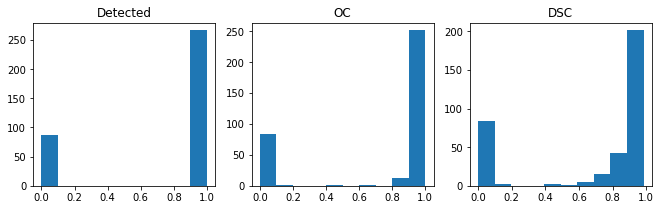

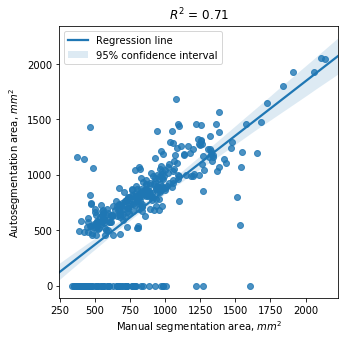

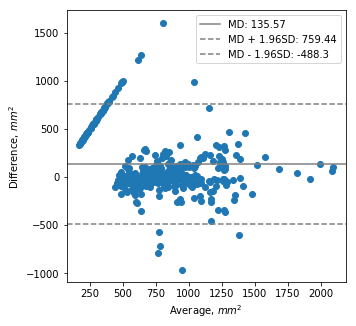

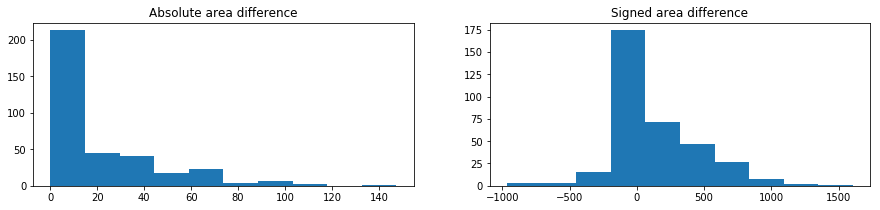

In [136]:
df_outcomes_test_unet_aug = get_outcomes(sub_names_test, ds_dir, results_dir_aug)

In [137]:
ds_dir = '../data/'
results_dir_simple = '../res/maps/T1w/plaq-u-net_simple/'
results_dir_aug = '../res/maps/T1w/plaq-u-net_aug/'

Mean TPR, OC, DSC:  0.8810198300283286 0.8735649802509556 0.6628093481772142
Median TPR, OC, DSC:  1.0 1.0 0.7759131293188549
IQR TPR, OC, DSC:  0.0 0.0210280373831776 0.3055199425373033
CP 90% CI TPR:  (0.8488417781993098, 0.9083132276976742)
MSE area, mm2:  217637.85552407932
Mean, median, IQR area difference, mm2:  33.57935310616573 26.3544009183 30.945759963300002
Mean, median area difference, IQR, relative:  0.4289609847376904 0.35772357723577236 0.3604951925649762
Mean area GT, pred:  833.0651558073654 468.1728045325779
Median area GT, pred:  799.0 488.0
Area difference ICC:  0.4331938461853994
R Spearman for areas:  0.5617071914992969
R2 for areas:  0.5111340028888864


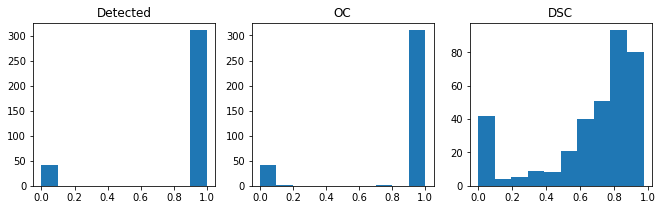

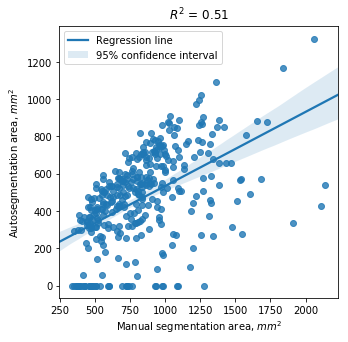

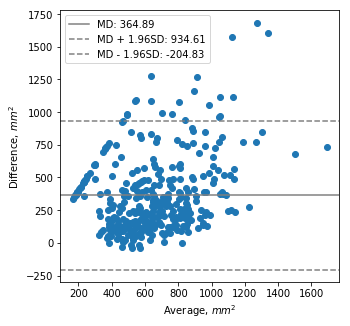

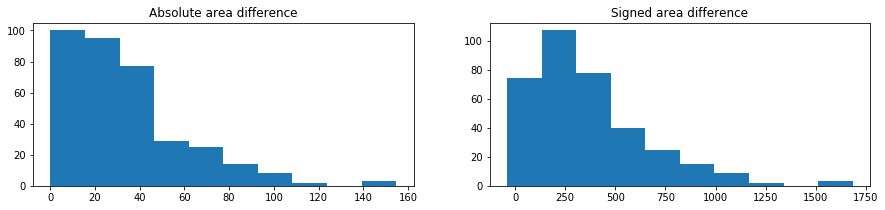

In [138]:
df_outcomes_test_plaqunet_simple = get_outcomes(sub_names_test, ds_dir, results_dir_simple)

Mean TPR, OC, DSC:  0.8555240793201133 0.8364612843628397 0.7571786545732941
Median TPR, OC, DSC:  1.0 0.9838056680161943 0.901686121919585
IQR TPR, OC, DSC:  0.0 0.04010314559587025 0.1687665328123118
CP 90% CI TPR:  (0.8211032155685053, 0.885407878689607)
MSE area, mm2:  88485.80736543909
Mean, median, IQR area difference, mm2:  18.652623737262324 9.917335537200001 23.783239853100003
Mean, median area difference, IQR, relative:  0.2686890052493755 0.14678899082568808 0.23996693684691017
Mean area GT, pred:  833.0651558073654 659.5127478753541
Median area GT, pred:  799.0 668.0
Area difference ICC:  0.7867770198520355
R Spearman for areas:  0.7889651022745222
R2 for areas:  0.7372562778932328


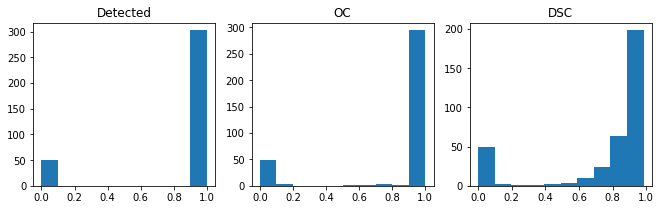

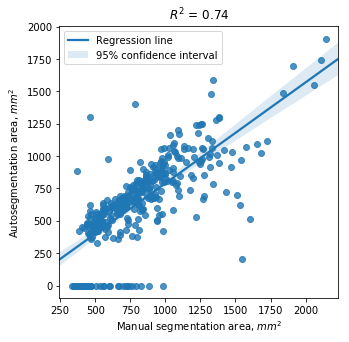

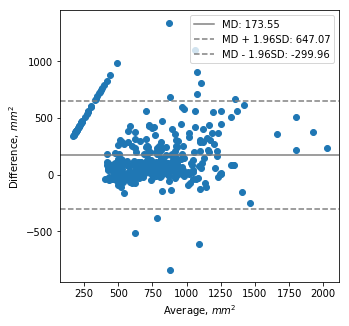

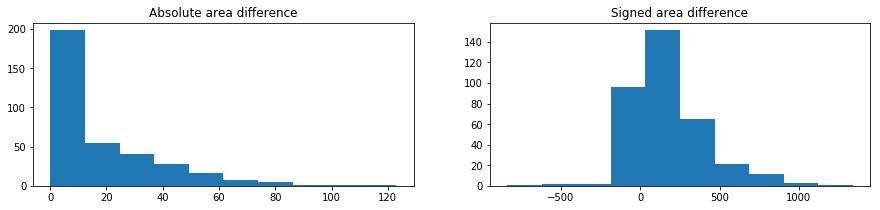

In [139]:
df_outcomes_test_plaqunet_aug = get_outcomes(sub_names_test, ds_dir, results_dir_aug)

In [140]:
ds_dir = '../data/'
results_dir_simple = '../res/maps/T1w/mask-rcnn_simple/'
results_dir_aug = '../res/maps/T1w/mask-rcnn_aug/'

Mean TPR, OC, DSC:  0.1813031161473088 0.17846602485012497 0.1510557522305352
Median TPR, OC, DSC:  0.0 0.0 0.0
IQR TPR, OC, DSC:  0.0 0.0 0.0
CP 90% CI TPR:  (0.14824475727078293, 0.21840956646686793)
MSE area, mm2:  674509.1161473087
Mean, median, IQR area difference, mm2:  65.96157112309123 64.09537226820001 46.831862259000005
Mean, median area difference, IQR, relative:  0.8538072744906819 1.0 0.0
Mean area GT, pred:  833.0651558073654 117.94334277620396
Median area GT, pred:  799.0 0.0
Area difference ICC:  0.022683401731534783
R Spearman for areas:  0.0025084009100228956
R2 for areas:  0.046828404580523245


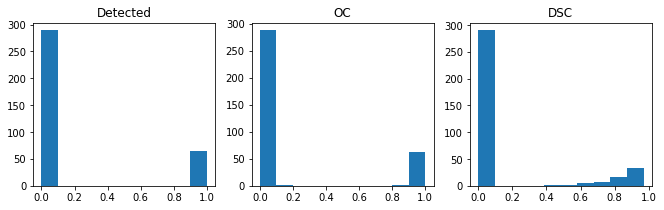

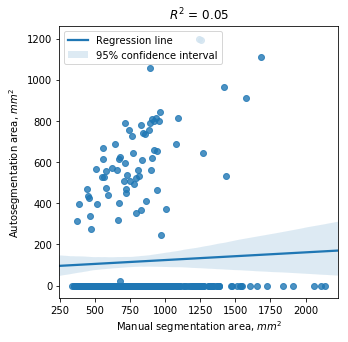

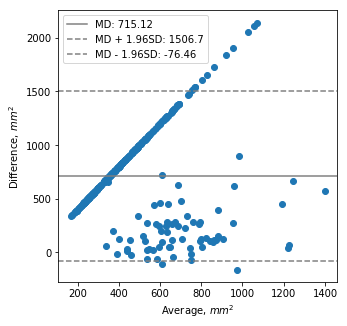

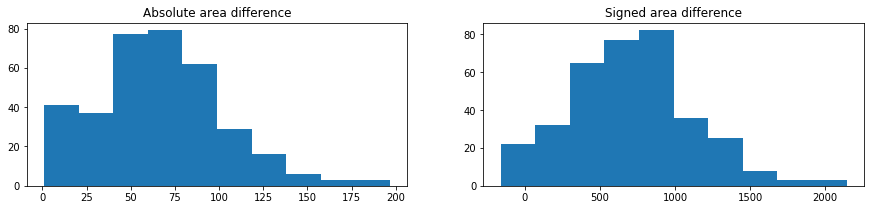

In [141]:
df_outcomes_test_maskrcnn_aug = get_outcomes(sub_names_test, ds_dir, results_dir_aug, mapstrategy=False)

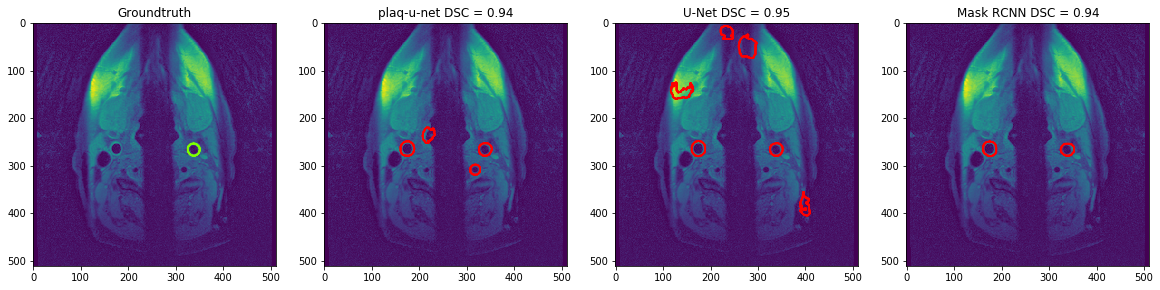

In [210]:
visualize_results('MUMC027', 'sl0002')

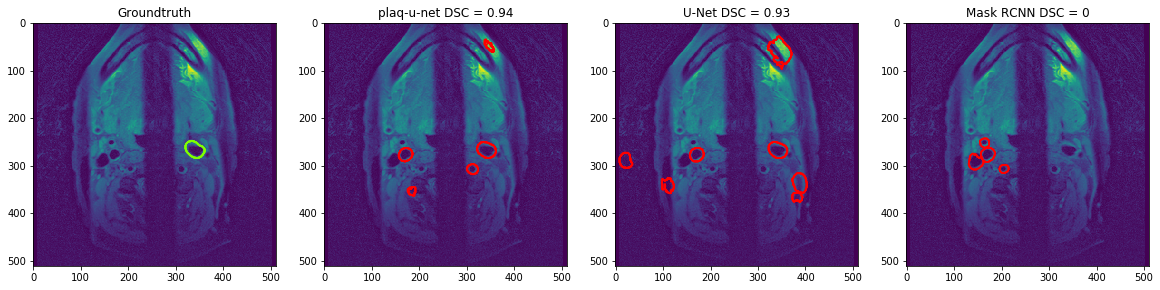

In [211]:
visualize_results('MUMC027', 'sl0007')

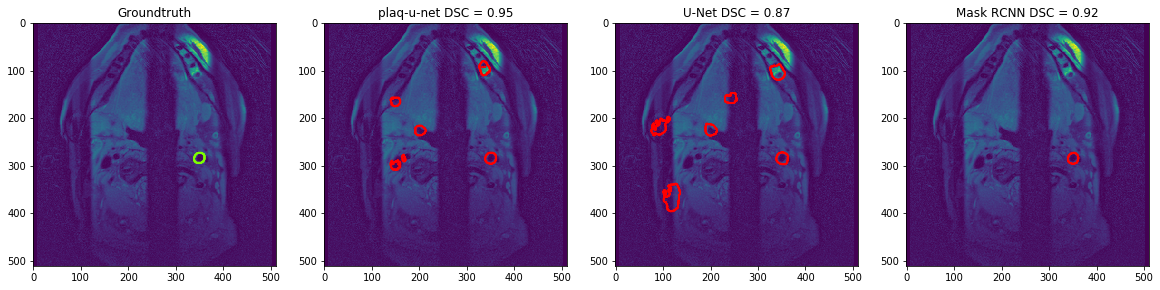

In [212]:
visualize_results('MUMC027', 'sl0015')

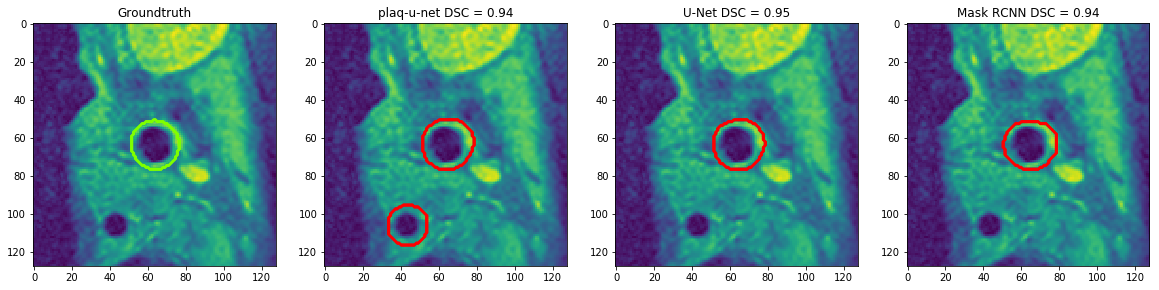

In [213]:
visualize_results('MUMC027', 'sl0002', large=True)

C:\ProgramData\Anaconda3\envs\segway\lib\site-packages\matplotlib\contour.py:1243: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


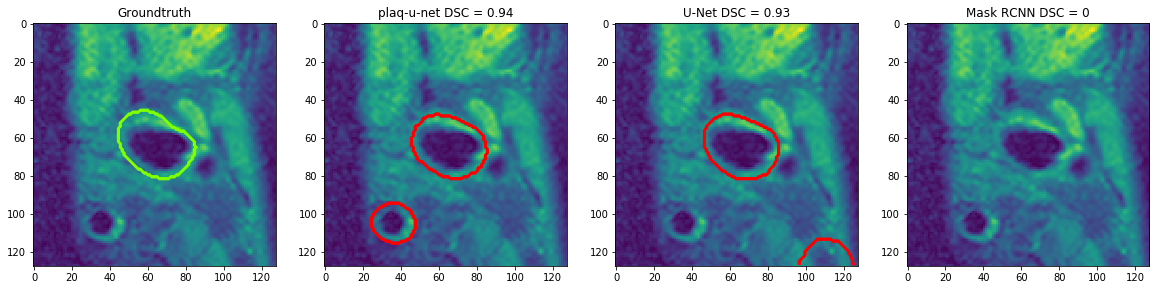

In [214]:
visualize_results('MUMC027', 'sl0007', large=True)

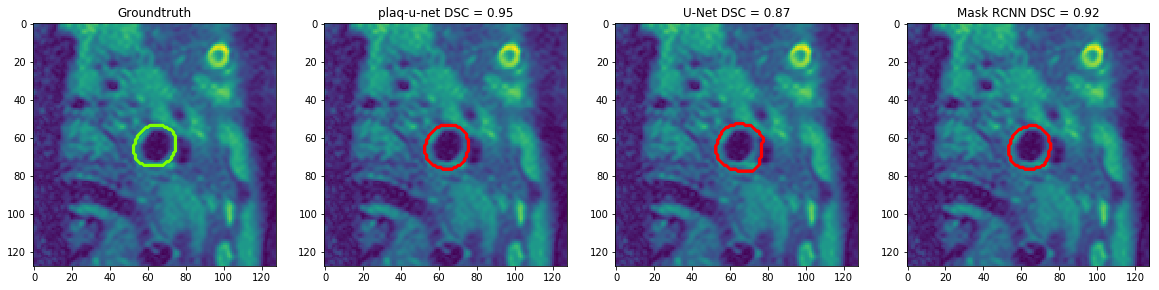

In [215]:
visualize_results('MUMC027', 'sl0015', large=True)

## EMC

In [149]:
sub_names_emc = ['EMC003', 'EMC004', 'EMC005', 'EMC007', 'EMC008', 'EMC009', 'EMC011', 'EMC015', 'EMC018', 'EMC020', 
                 'EMC024', 'EMC027', 'EMC029', 'EMC031', 'EMC032', 'EMC034', 'EMC035', 'EMC036', 'EMC038', 'EMC041', 
                 'EMC042', 'EMC043', 'EMC045', 'EMC046', 'EMC047', 'EMC048', 'EMC049', 'EMC050', 'EMC051', 'EMC052', 
                 'EMC054', 'EMC055', 'EMC056', 'EMC057']

In [150]:
ds_dir = '../data/'
results_dir_simple = '../res/maps/T1w/u-net_simple/'
results_dir_aug = '../res/maps/T1w/u-net_aug/'

Mean TPR, OC, DSC:  0.6947162426614482 0.6731722568500312 0.6028880180389821
Median TPR, OC, DSC:  1.0 0.9696969696969697 0.837037037037037
IQR TPR, OC, DSC:  1.0 0.9973360859263043 0.9246311927223152
CP 90% CI TPR:  (0.6594443334045442, 0.7283035876297254)
MSE area, mm2:  26179.9843444227
Mean, median, IQR area difference, mm2:  35.5567086150685 25.390625 46.50998935500001
Mean, median area difference, IQR, relative:  0.4348013215967285 0.22647058823529412 0.8959919814413233
Mean area GT, pred:  317.42074363992174 219.18199608610567
Median area GT, pred:  287.0 230.0
Area difference ICC:  0.741531618865352
R Spearman for areas:  0.7233679307000747
R2 for areas:  0.7089202023106963


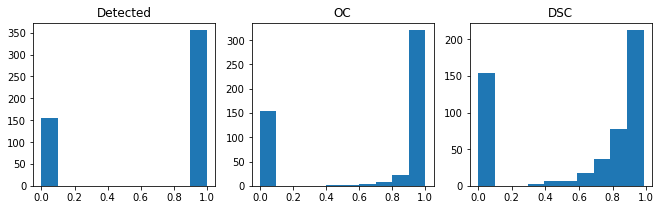

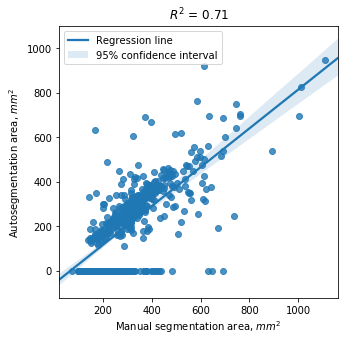

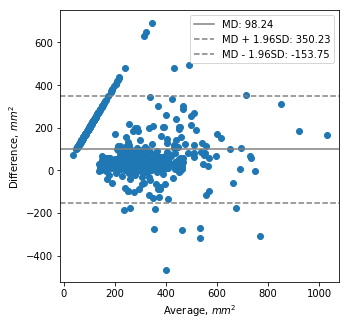

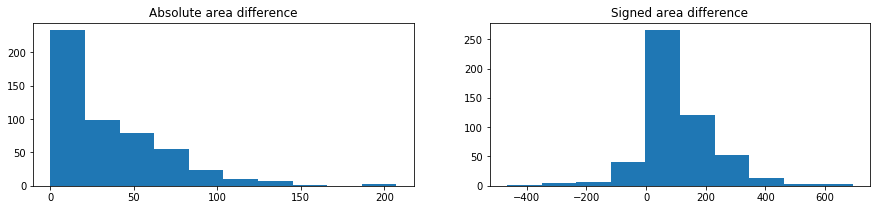

In [151]:
df_outcomes_emc_unet_aug = get_outcomes(sub_names_emc, ds_dir, results_dir_aug, cut=False)

In [152]:
ds_dir = '../data/'
results_dir_simple = '../res/maps/T1w/plaq-u-net_simple/'
results_dir_aug = '../res/maps/T1w/plaq-u-net_aug/'

Mean TPR, OC, DSC:  0.5342465753424658 0.5297159371865922 0.32889753768955055
Median TPR, OC, DSC:  1.0 0.9902912621359223 0.3012987012987013
IQR TPR, OC, DSC:  1.0 1.0 0.6475118290096264
CP 90% CI TPR:  (0.496893438811138, 0.5713042284917957)
MSE area, mm2:  85700.457925636
Mean, median, IQR area difference, mm2:  73.82506224953035 64.00731654 59.072172975000015
Mean, median area difference, IQR, relative:  0.7440334485334504 0.8226299694189603 0.4918297787978375
Mean area GT, pred:  317.42074363992174 74.73972602739725
Median area GT, pred:  287.0 62.0
Area difference ICC:  0.029457244940566247
R Spearman for areas:  0.148452673086074
R2 for areas:  0.054427197197134736


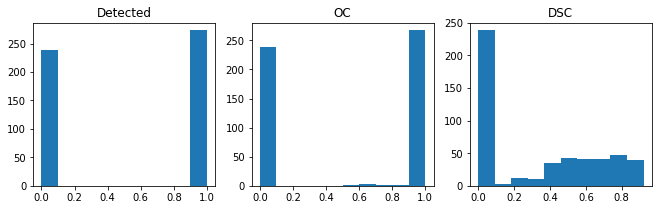

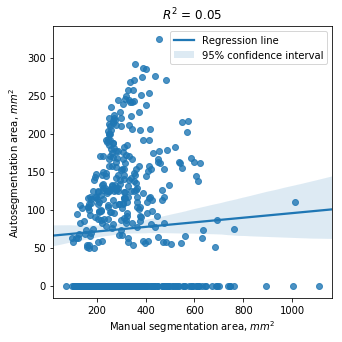

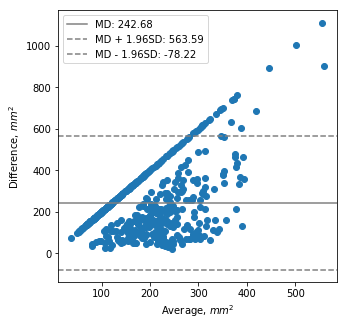

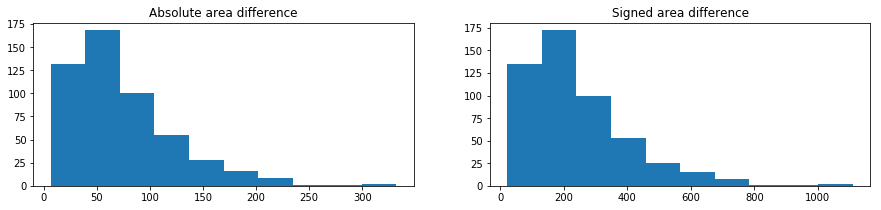

In [153]:
df_outcomes_emc_plaqunet_simple = get_outcomes(sub_names_emc, ds_dir, results_dir_simple, cut=False)

Mean TPR, OC, DSC:  0.8317025440313112 0.8229656315478037 0.6765513313503624
Median TPR, OC, DSC:  1.0 1.0 0.821917808219178
IQR TPR, OC, DSC:  0.0 0.021610084706196186 0.2630629277860572
CP 90% CI TPR:  (0.8020860731518331, 0.8584261977439656)
MSE area, mm2:  33084.86888454012
Mean, median, IQR area difference, mm2:  39.075187058317034 25.423466850000008 37.38745125000001
Mean, median area difference, IQR, relative:  0.3962099701543263 0.2840909090909091 0.3128896305848641
Mean area GT, pred:  317.42074363992174 190.43835616438355
Median area GT, pred:  287.0 190.0
Area difference ICC:  0.5276581676782937
R Spearman for areas:  0.6245088052653952
R2 for areas:  0.5332797099441869


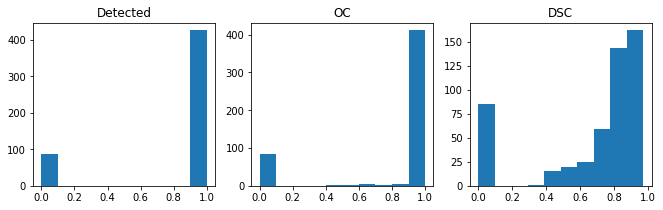

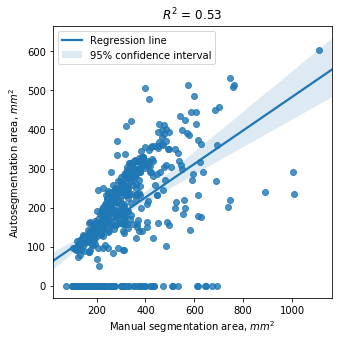

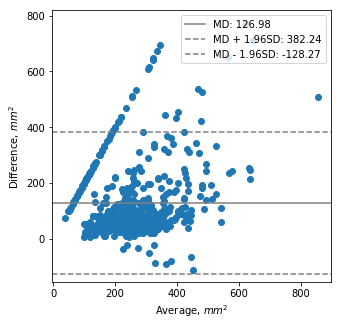

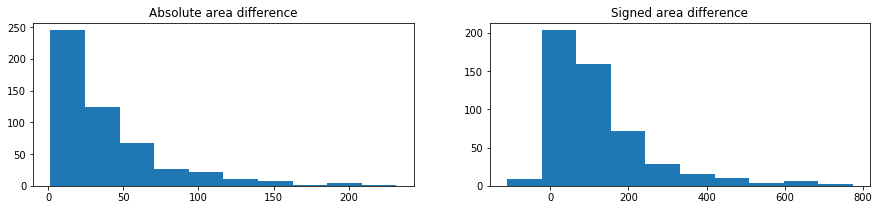

In [154]:
df_outcomes_emc_plaqunet_aug = get_outcomes(sub_names_emc, ds_dir, results_dir_aug, cut=False)

In [155]:
ds_dir = '../data/'
results_dir_simple = '../res/maps/T1w/mask-rcnn_simple/'
results_dir_aug = '../res/maps/T1w/mask-rcnn_aug/'

Mean TPR, OC, DSC:  0.01761252446183953 0.017852150644993812 0.01187294725562506
Median TPR, OC, DSC:  0.0 0.0 0.0
IQR TPR, OC, DSC:  0.0 0.0 0.0
CP 90% CI TPR:  (0.009218229505547496, 0.030532713913909916)
MSE area, mm2:  121016.82778864971
Mean, median, IQR area difference, mm2:  95.64887950890413 85.84158807000001 50.54783409000001
Mean, median area difference, IQR, relative:  0.9902742234565018 1.0 0.0
Mean area GT, pred:  317.42074363992174 2.816046966731898
Median area GT, pred:  287.0 0.0
Area difference ICC:  -0.0014560356515182227
R Spearman for areas:  0.0062062811901862115
R2 for areas:  -0.013873545268276569


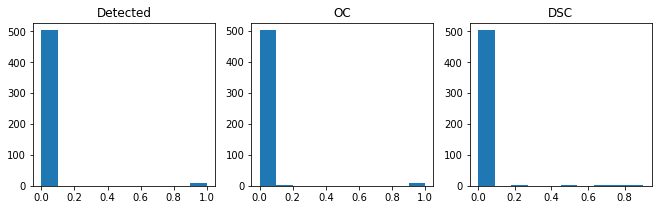

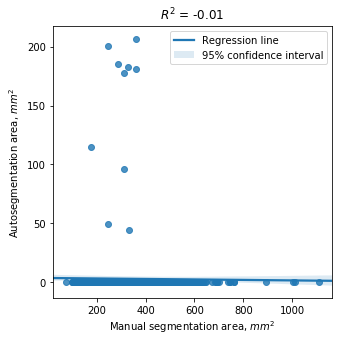

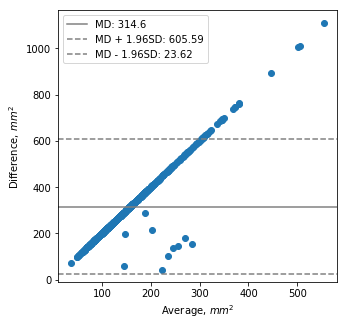

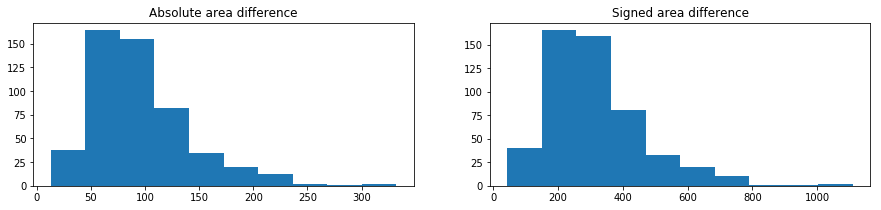

In [156]:
df_outcomes_emc_maskrcnn_aug = get_outcomes(sub_names_emc, ds_dir, results_dir_aug, cut=False, mapstrategy=False)

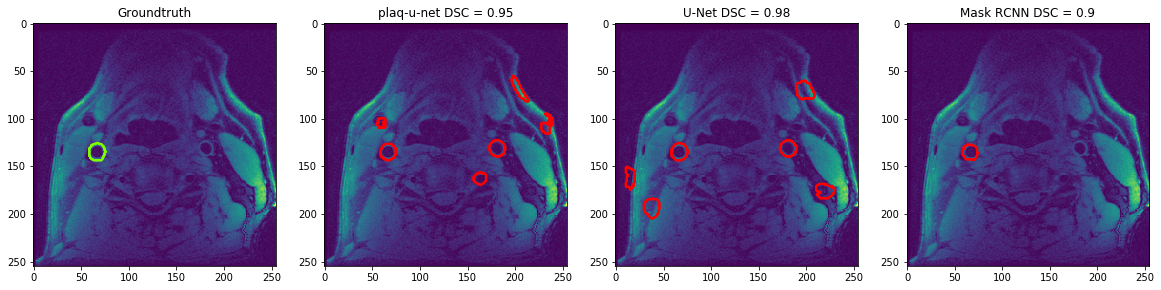

In [268]:
visualize_results('EMC004', 'sl0002', cut=False)

C:\ProgramData\Anaconda3\envs\segway\lib\site-packages\matplotlib\contour.py:1243: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


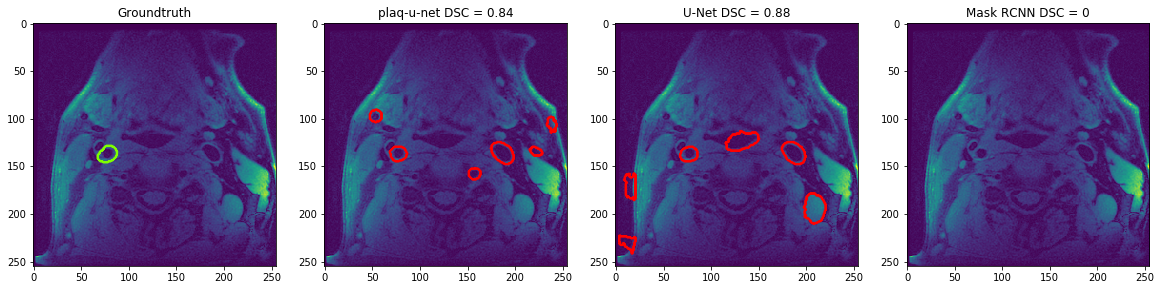

In [270]:
visualize_results('EMC004', 'sl0009', cut=False)

C:\ProgramData\Anaconda3\envs\segway\lib\site-packages\matplotlib\contour.py:1243: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


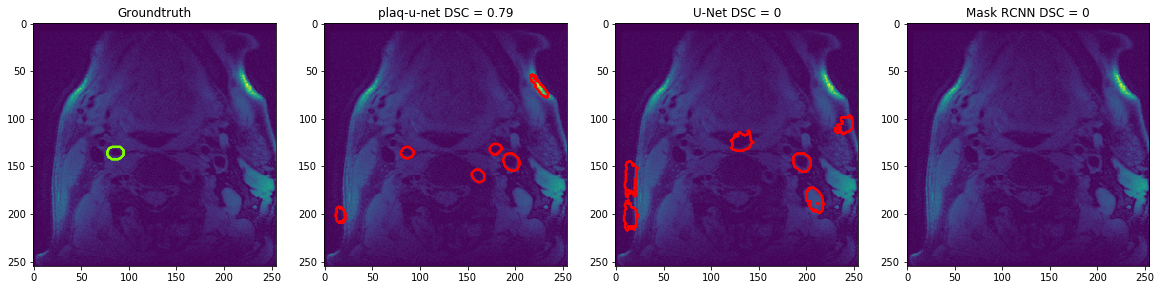

In [273]:
visualize_results('EMC004', 'sl0013', cut=False)

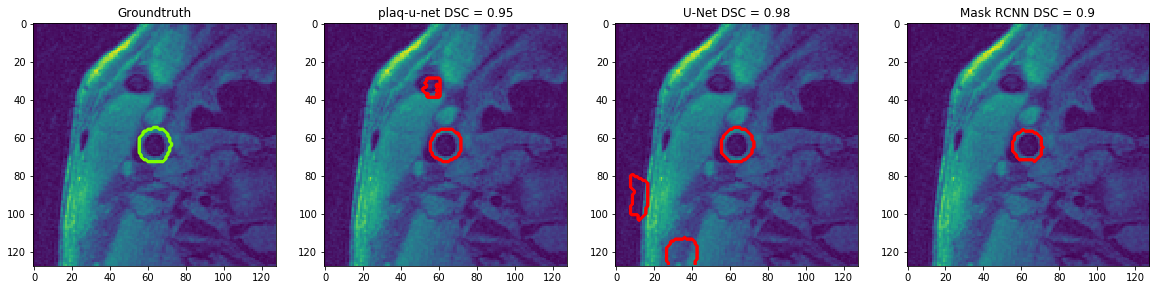

In [274]:
visualize_results('EMC004', 'sl0002', large = True, cut=False)

C:\ProgramData\Anaconda3\envs\segway\lib\site-packages\matplotlib\contour.py:1243: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


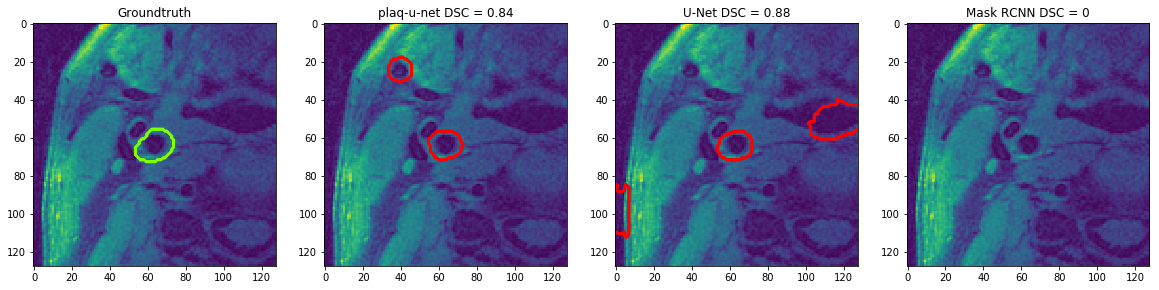

In [275]:
visualize_results('EMC004', 'sl0009', large = True, cut=False)

C:\ProgramData\Anaconda3\envs\segway\lib\site-packages\matplotlib\contour.py:1243: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


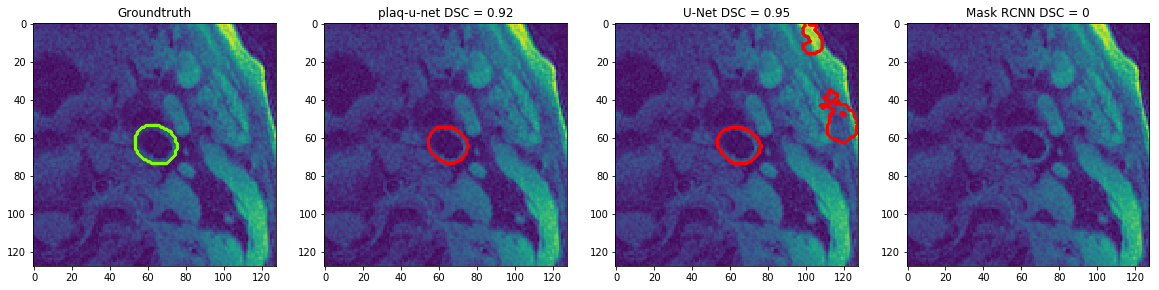

In [276]:
visualize_results('EMC009', 'sl0013', large = True, cut=False)

## Other modalities

### T2w

In [163]:
sub_names_test = ['AMC012', 'AMC006', 'MUMC094', 'MUMC027', 'MUMC079', 'MUMC052', 'MUMC127', 'MUMC071', 'MUMC038',
                  'MUMC093', 'MUMC107', 'MUMC022', 'MUMC114', 'MUMC115', 'MUMC069', 'MUMC130', 'MUMC036', 'MUMC007', 
                  'MUMC059', 'MUMC080', 'UMCU036', 'UMCU025', 'UMCU008', 'UMCU034']

In [164]:
ds_dir = '../data/'
results_dir_simple = '../res/maps/T2w/u-net_simple/'
results_dir_aug = '../res/maps/T2w/u-net_aug/'

Mean TPR, OC, DSC:  0.5892351274787535 0.5691726350124107 0.5232588075236977
Median TPR, OC, DSC:  1.0 0.9371833839918946 0.7959493670886076
IQR TPR, OC, DSC:  1.0 0.981574539363484 0.9288956127080181
CP 90% CI TPR:  (0.5443067887237696, 0.6330421054345894)
MSE area, mm2:  283238.5552407932
Mean, median, IQR area difference, mm2:  34.643039629395474 23.966894214900005 48.48475151520002
Mean, median area difference, IQR, relative:  0.5087303066196792 0.2965931863727455 0.9146067415730337
Mean area GT, pred:  833.0651558073654 577.2634560906515
Median area GT, pred:  799.0 662.0
Area difference ICC:  0.5239276703039162
R Spearman for areas:  0.5291631214384467
R2 for areas:  0.4639074945182579


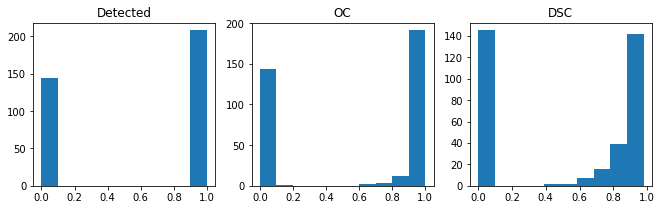

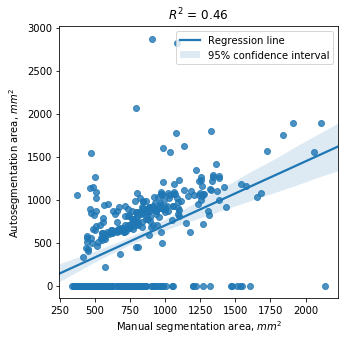

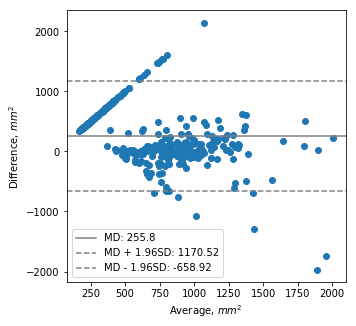

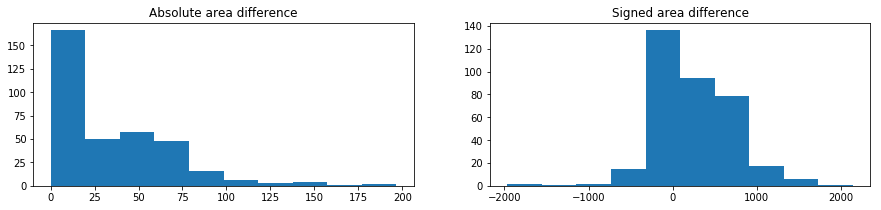

In [165]:
df_outcomes_T2w_unet_aug = get_outcomes(sub_names_test, ds_dir, results_dir_aug)

In [166]:
ds_dir = '../data/'
results_dir_simple = '../res/maps/T2w/plaq-u-net_simple/'
results_dir_aug = '../res/maps/T2w/plaq-u-net_aug/'

Mean TPR, OC, DSC:  0.7223796033994334 0.7137045535244169 0.6221226349669431
Median TPR, OC, DSC:  1.0 0.9842105263157894 0.8404575556893438
IQR TPR, OC, DSC:  1.0 0.9792284866468842 0.9026839826839828
CP 90% CI TPR:  (0.680452032057628, 0.7615019090619991)
MSE area, mm2:  210195.03116147307
Mean, median, IQR area difference, mm2:  30.161977254938247 19.742843893500005 34.618847199300006
Mean, median area difference, IQR, relative:  0.4143309150461078 0.25374105400130126 0.7947120312389774
Mean area GT, pred:  833.0651558073654 528.2606232294618
Median area GT, pred:  799.0 587.0
Area difference ICC:  0.5348933794647095
R Spearman for areas:  0.5975603865174182
R2 for areas:  0.5106379787682787


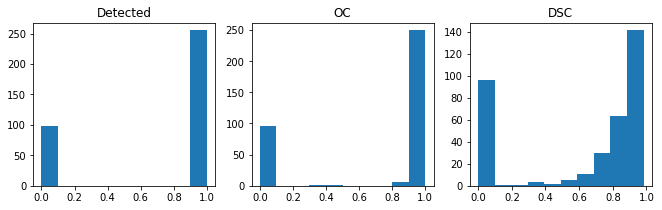

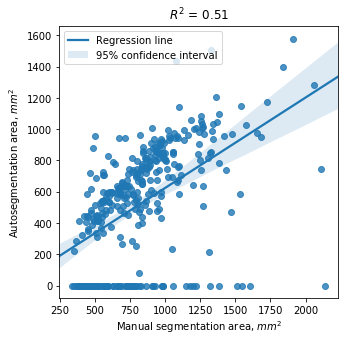

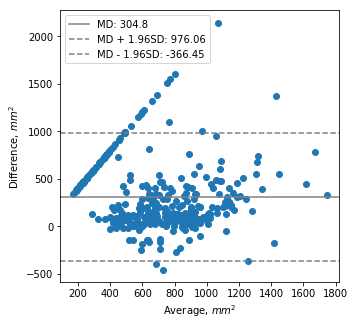

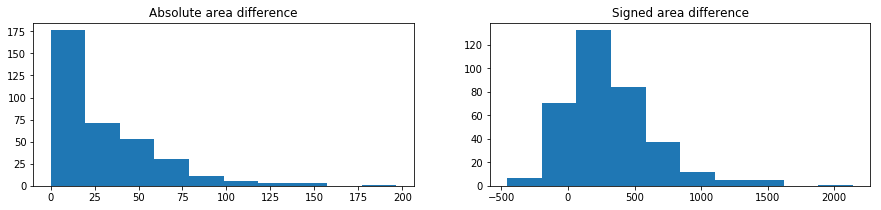

In [167]:
df_outcomes_T2w_plaqunet_aug = get_outcomes(sub_names_test, ds_dir, results_dir_aug)

In [168]:
ds_dir = '../data/'
results_dir_simple = '../res/maps/T2w/mask-rcnn_simple/'
results_dir_aug = '../res/maps/T2w/mask-rcnn_aug/'

Mean TPR, OC, DSC:  0.21813031161473087 0.21523517590738203 0.1731637525628795
Median TPR, OC, DSC:  0.0 0.0 0.0
IQR TPR, OC, DSC:  0.0 0.0 0.0
CP 90% CI TPR:  (0.18242199193430075, 0.25740714652621877)
MSE area, mm2:  672554.3172804533
Mean, median, IQR area difference, mm2:  65.37991226617224 63.8198907255 48.39292433430001
Mean, median area difference, IQR, relative:  0.8397514768149505 1.0 0.0
Mean area GT, pred:  833.0651558073654 125.3314447592068
Median area GT, pred:  799.0 0.0
Area difference ICC:  -0.008728660722632299
R Spearman for areas:  -0.0353251095982278
R2 for areas:  -0.01769614089867152


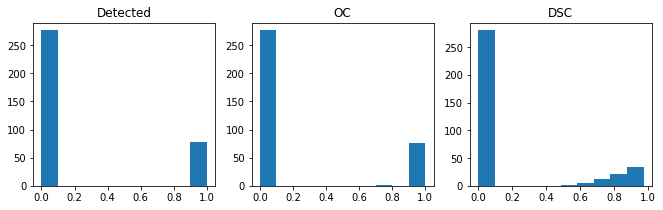

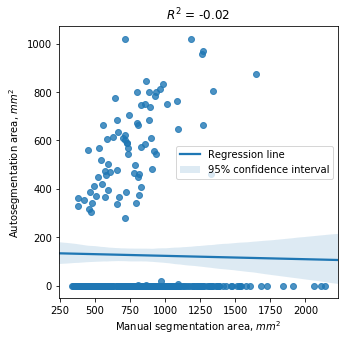

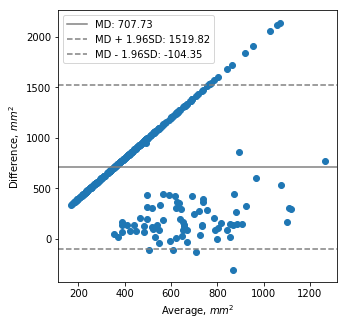

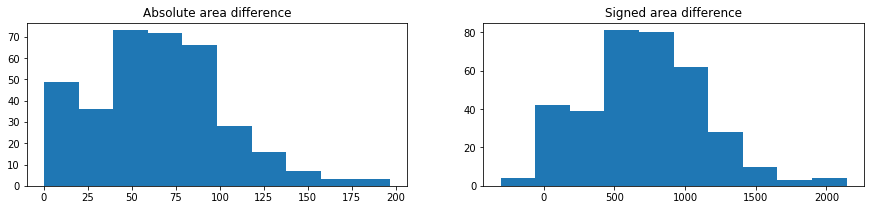

In [169]:
df_outcomes_T2w_maskrcnn_aug = get_outcomes(sub_names_test, ds_dir, results_dir_aug, mapstrategy=False)

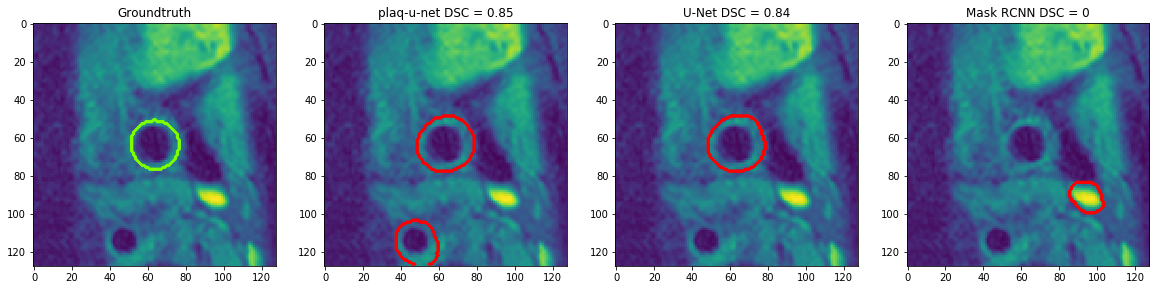

In [240]:
visualize_results('MUMC027', 'sl0002', large=True, modality = 'T2w')

C:\ProgramData\Anaconda3\envs\segway\lib\site-packages\matplotlib\contour.py:1243: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


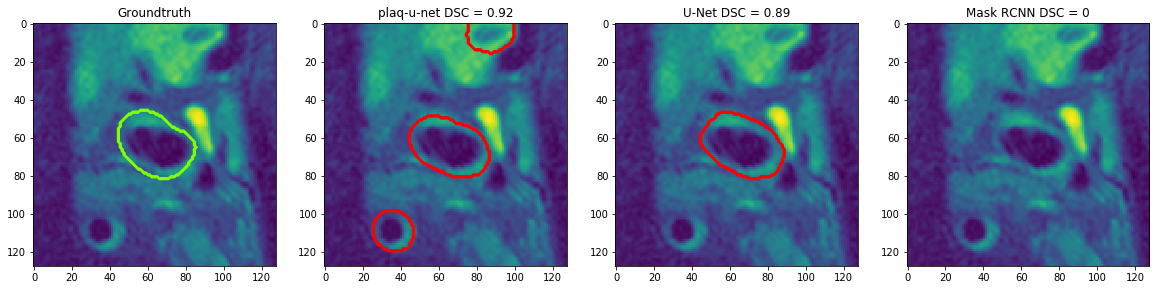

In [241]:
visualize_results('MUMC027', 'sl0007', large=True, modality = 'T2w')

C:\ProgramData\Anaconda3\envs\segway\lib\site-packages\matplotlib\contour.py:1243: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


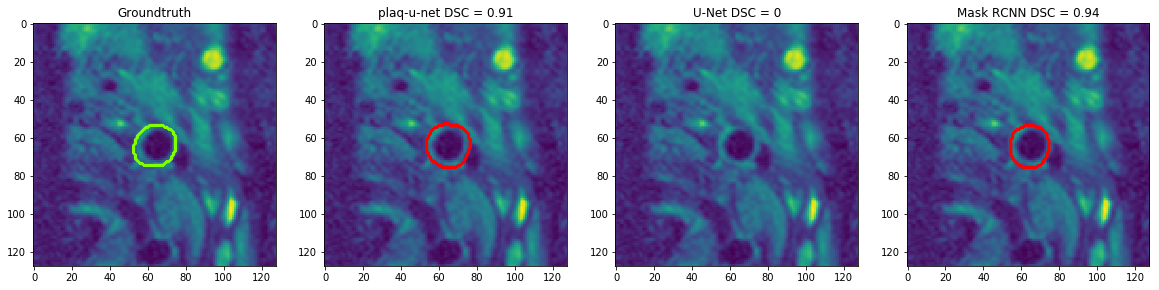

In [242]:
visualize_results('MUMC027', 'sl0015', large=True, modality = 'T2w')

### T1w CE

In [170]:
ds_dir = '../data/'
results_dir_simple = '../res/maps/T1wCE/u-net_simple/'
results_dir_aug = '../res/maps/T1wCE/u-net_aug/'

Mean TPR, OC, DSC:  0.6572237960339944 0.6346903582397824 0.5777607184654987
Median TPR, OC, DSC:  1.0 0.9419354838709677 0.8672798948751642
IQR TPR, OC, DSC:  1.0 0.9808673469387755 0.9263531499556344
CP 90% CI TPR:  (0.6133759076327068, 0.6990931319051781)
MSE area, mm2:  229855.28895184136
Mean, median, IQR area difference, mm2:  31.10027935552267 16.6207197429 44.62800991740001
Mean, median area difference, IQR, relative:  0.4647906259102864 0.1966824644549763 0.9115826702033598
Mean area GT, pred:  833.0651558073654 679.5269121813031
Median area GT, pred:  799.0 782.0
Area difference ICC:  0.5687434481749224
R Spearman for areas:  0.5196379978536405
R2 for areas:  0.4650138702118374


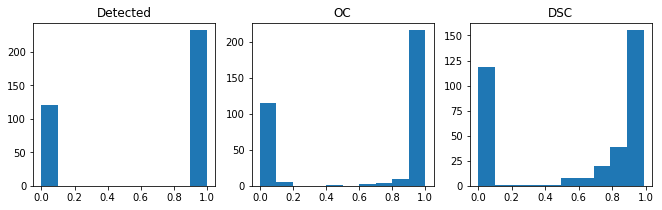

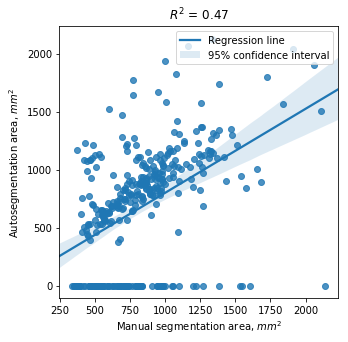

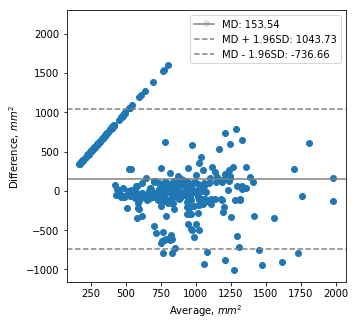

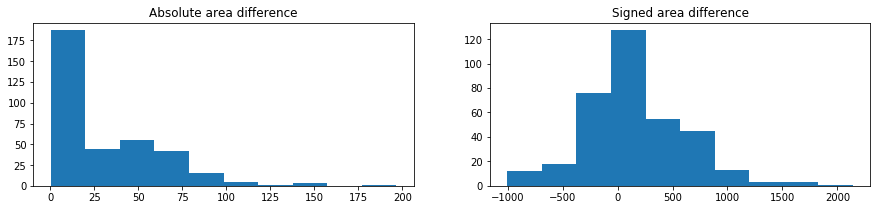

In [171]:
df_outcomes_T1wCE_unet_aug = get_outcomes(sub_names_test, ds_dir, results_dir_aug)

In [172]:
ds_dir = '../data/'
results_dir_simple = '../res/maps/T1wCE/plaq-u-net_simple/'
results_dir_aug = '../res/maps/T1wCE/plaq-u-net_aug/'

Mean TPR, OC, DSC:  0.7620396600566572 0.7461354543831455 0.6500304294982537
Median TPR, OC, DSC:  1.0 0.9787735849056604 0.8510266491917868
IQR TPR, OC, DSC:  0.0 0.22234791976562684 0.5190258489648544
CP 90% CI TPR:  (0.721771900946806, 0.798994567724988)
MSE area, mm2:  178383.56373937678
Mean, median, IQR area difference, mm2:  27.93731422078301 18.549090541800002 37.557316988100006
Mean, median area difference, IQR, relative:  0.3942838811384186 0.23516483516483516 0.518081550802139
Mean area GT, pred:  833.0651558073654 587.3597733711048
Median area GT, pred:  799.0 633.0
Area difference ICC:  0.5739978665728266
R Spearman for areas:  0.5590901319660353
R2 for areas:  0.5076576705162131


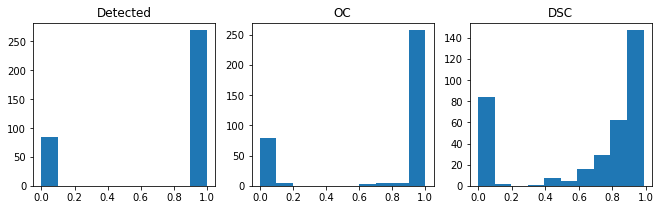

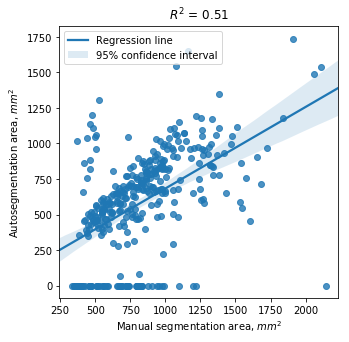

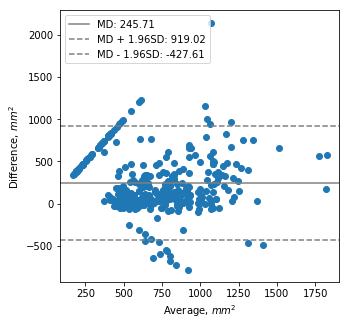

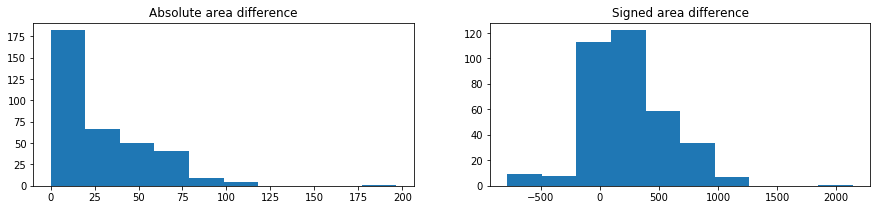

In [173]:
df_outcomes_T1wCE_plaqunet_aug = get_outcomes(sub_names_test, ds_dir, results_dir_aug)

In [174]:
ds_dir = '../data/'
results_dir_simple = '../res/maps/T1wCE/mask-rcnn_simple/'
results_dir_aug = '../res/maps/T1wCE/mask-rcnn_aug/'

Mean TPR, OC, DSC:  0.31444759206798867 0.3072029156724854 0.2634733256785968
Median TPR, OC, DSC:  0.0 0.0 0.0
IQR TPR, OC, DSC:  1.0 0.9558998808104887 0.742998352553542
CP 90% CI TPR:  (0.2736577445685367, 0.35757459145457565)
MSE area, mm2:  601806.6232294617
Mean, median, IQR area difference, mm2:  58.74650401418925 54.2698639119 56.473716253500015
Mean, median area difference, IQR, relative:  0.7468214017585751 1.0 0.6155555555555556
Mean area GT, pred:  833.0651558073654 203.05949008498584
Median area GT, pred:  799.0 0.0
Area difference ICC:  -0.00846988859261265
R Spearman for areas:  0.004828832499369079
R2 for areas:  -0.012458233979635146


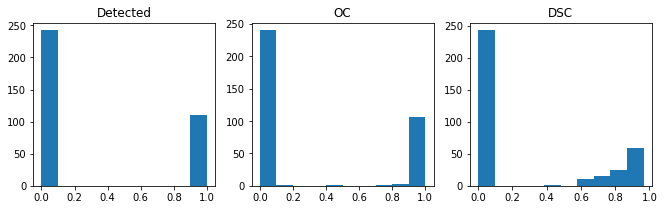

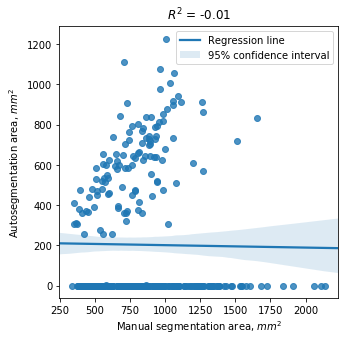

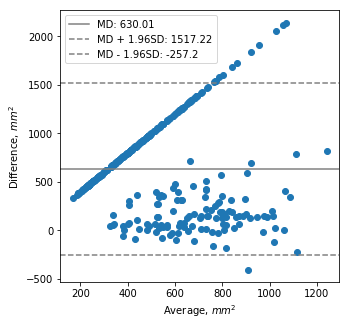

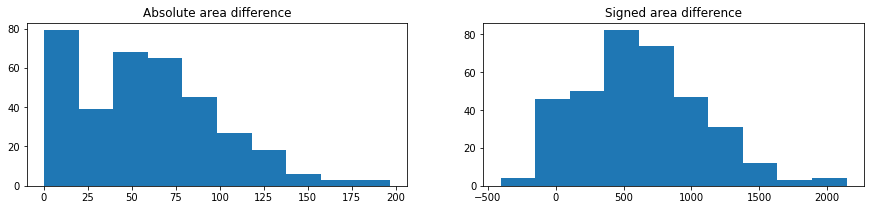

In [175]:
df_outcomes_T1wCE_maskrcnn_aug = get_outcomes(sub_names_test, ds_dir, results_dir_aug, mapstrategy=False)

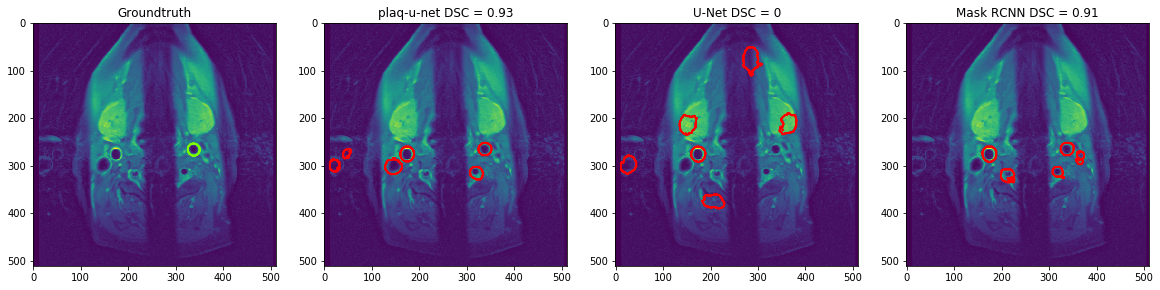

In [250]:
visualize_results('MUMC027', 'sl0002', modality = 'T1wCE')

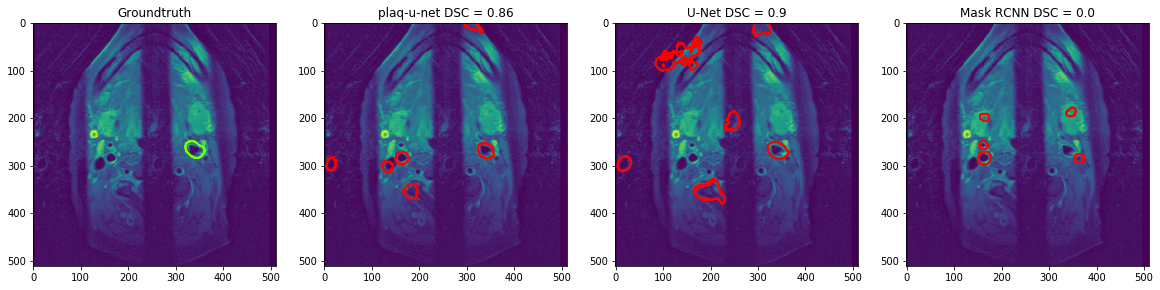

In [251]:
visualize_results('MUMC027', 'sl0007', modality = 'T1wCE')

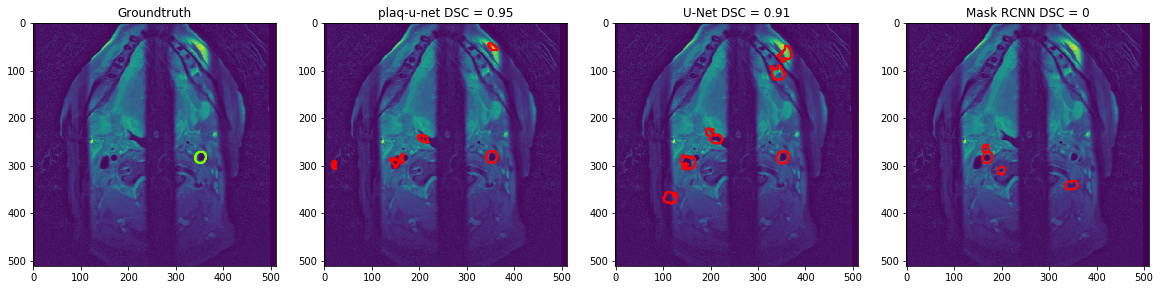

In [252]:
visualize_results('MUMC027', 'sl0014', modality = 'T1wCE')

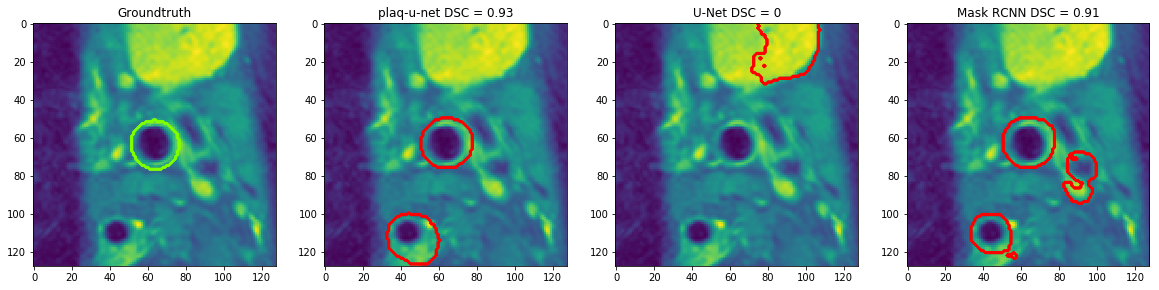

In [246]:
visualize_results('MUMC027', 'sl0002', large=True, modality = 'T1wCE')

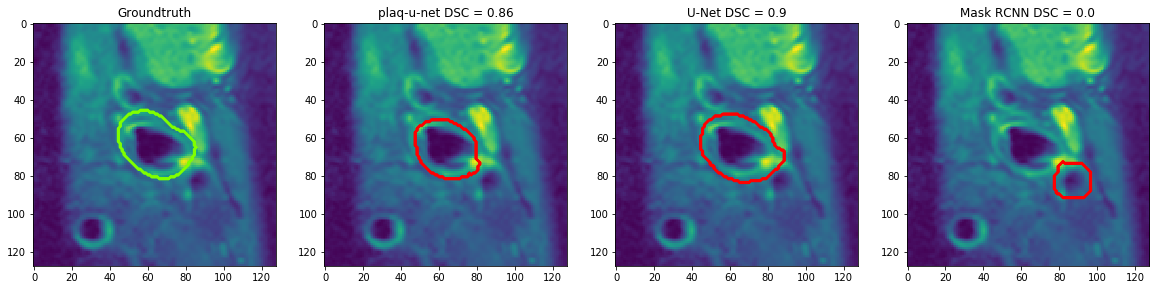

In [247]:
visualize_results('MUMC027', 'sl0007', large=True, modality = 'T1wCE')

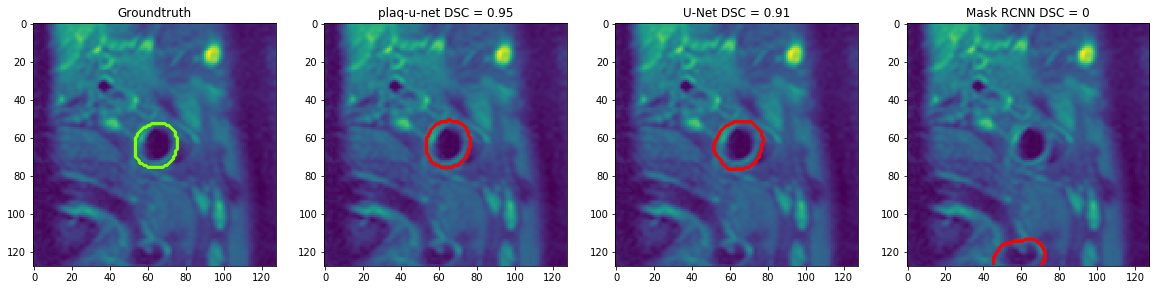

In [249]:
visualize_results('MUMC027', 'sl0014', large=True, modality = 'T1wCE')

## Comparison

In [218]:
from scipy.stats import mannwhitneyu

def compare_scores(df_1, df_2, score):
    
    list_1 = np.array([item for items in list(df_1[score]) for item in items])
    list_2 = np.array([item for items in list(df_2[score]) for item in items])
    
    U1, p = mannwhitneyu(list_1, list_2)
    
    return p

def compare_models(df_1, df_2):
    
    print ('Slice TPR: ', compare_scores(df_1, df_2, 'detect_slice'))
    print ('Slice OC: ', compare_scores(df_1, df_2, 'overlap_slice'))
    print ('Slice DSC: ', compare_scores(df_1, df_2, 'dice_slice'))

    print ('Slice area difference: ', 
       compare_scores(df_1, df_outcomes_test_plaqunet_aug, 'area_difference_slice'))
    
    

### plaq-u-net vs plaq-u-net with data augmentation

In [220]:
print ('test set:')

compare_models(df_outcomes_test_plaqunet_simple, df_outcomes_test_plaqunet_aug)

print ('external test set:')

compare_models(df_outcomes_emc_plaqunet_simple, df_outcomes_emc_plaqunet_aug)

test set:
Slice TPR:  0.3170557357999023
Slice OC:  2.5555790033640505e-13
Slice DSC:  2.594397163193229e-20
Slice area difference:  2.14693510689804e-21
external test set:
Slice TPR:  1.735312011461316e-24
Slice OC:  5.721757892180425e-15
Slice DSC:  1.0440548004281151e-60
Slice area difference:  8.845438636811409e-88


### plaq-u-net vs U-Net vs mask R-CNN

In [221]:
print ('test set:')

compare_models(df_outcomes_test_plaqunet_aug, df_outcomes_test_unet_aug)

print ('external test set:')

compare_models(df_outcomes_emc_plaqunet_aug, df_outcomes_emc_unet_aug)

test set:
Slice TPR:  0.0006404307622055417
Slice OC:  6.555865489675104e-14
Slice DSC:  0.1404564013565011
Slice area difference:  1.0
external test set:
Slice TPR:  2.631912305989873e-07
Slice OC:  6.576673131259678e-32
Slice DSC:  0.18021997568676662
Slice area difference:  1.6195164265017101e-28


### plaq-u-net vs U-Net vs mask R-CNN on other MRI modalities

In [222]:
print ('T2w:')

compare_models(df_outcomes_T2w_plaqunet_aug, df_outcomes_T2w_unet_aug)

print ('T1w CE:')

compare_models(df_outcomes_T1wCE_plaqunet_aug, df_outcomes_T1wCE_unet_aug)

T2w:
Slice TPR:  0.00019902241811792438
Slice OC:  1.2434205861548639e-12
Slice DSC:  0.16882392151024916
Slice area difference:  1.0631740791194852e-09
T1w CE:
Slice TPR:  0.002174812629288426
Slice OC:  2.244637224294185e-10
Slice DSC:  0.12401093366352978
Slice area difference:  3.2557977354982144e-06
